# Plotting Key Global Timeseries in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [8]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
plotfolder='/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/'
dpi=300
### USER EDIT stop

import matplotlib as mpl
import os
%matplotlib inline
mpl.rcParams['figure.dpi']= dpi

os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [3]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
tosga = datastore.search(variable="tosga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['tosga'].resample(time = '1YE').mean('time').load()
sosga = datastore.search(variable="sosga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['sosga'].resample(time = '1YE').mean('time').load()

thetaoga = datastore.search(variable="thetaoga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['thetaoga'].resample(time = '1YE').mean('time').load()


## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [5]:
catalog = intake.cat.access_nri

In [6]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='temp_global_ave',frequency="1mon")
temp_global_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['temp_global_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [7]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='temp_surface_ave',frequency="1mon")
temp_surface_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['temp_surface_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [8]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='salt_surface_ave',frequency="1mon")
salt_surface_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['salt_surface_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [9]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='ke_tot',frequency="1mon")
ke_tot=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['ke_tot'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

## Plot Timeseries

Text(0.5, 1.0, '(d) Global average kinetic energy')

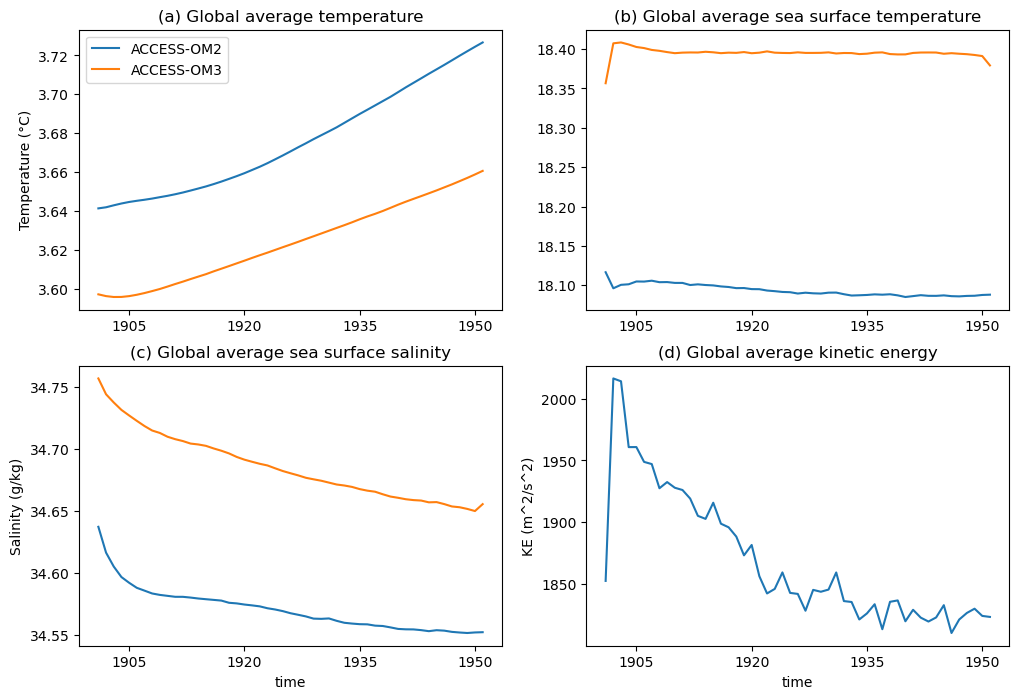

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(221)
temp_global_ave.plot(label="ACCESS-OM2")
thetaoga.plot(label="ACCESS-OM3")
plt.legend()
plt.ylabel('Temperature (°C)')
plt.xlabel('')
plt.title('(a) Global average temperature')

plt.subplot(222)
temp_surface_ave.plot(label="ACCESS-OM2")
tosga.plot(label="ACCESS-OM3")
plt.ylabel('')
plt.xlabel('')
plt.title('(b) Global average sea surface temperature')

plt.subplot(223)
salt_surface_ave.plot(label="ACCESS-OM2")
sosga.plot(label="ACCESS-OM3")
plt.ylabel('Salinity (g/kg)')
plt.title('(c) Global average sea surface salinity')


plt.subplot(224)
ke_tot.plot(label="ACCESS-OM2")
#no_ke_diagnostic_for_om3.plot(label="ACCESS-OM3")
plt.ylabel('KE (m^2/s^2)')
plt.title('(d) Global average kinetic energy')

In [11]:
client.close()